In [325]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math

import itertools
import re

from collections import Counter, defaultdict
import umap

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

In [ ]:
def count_entries_across_sublists(list_of_lists):
    # Flatten the list of lists
    flattened_list = [item for sublist in list_of_lists for item in sublist]
    # Count occurrences of each element across all sublists
    return Counter(flattened_list)

def count_entries_with_indices(list_of_lists):
    # Initialize a defaultdict to store occurrences with indices
    counts_with_indices = defaultdict(list)
    
    # Loop through each sublist and its index
    for sublist_index, sublist in enumerate(list_of_lists):
        # Loop through each item in the sublist and its index
        for item_index, item in enumerate(sublist):
            # Append the (sublist_index, item_index) to the list of occurrences for that item
            counts_with_indices[item].append((sublist_index, item_index))
    
    return counts_with_indices

In [360]:
# Load pre-trained Pythia model and tokenizer
model_name = "EleutherAI/pythia-410m-deduped"  # Adjust as necessary
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Hook function to capture activations
layer = model.base_model.layers[-3].mlp  # You can adjust this layer if needed

act = []

def hook_fn(module, input, output):
    act.append(output)

handle = layer.register_forward_hook(hook_fn)

def generate_until_period(input_text, temperature=0.5, max_length=50):
    # Tokenize the input text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)

    # Generate tokens until a period is encountered
    generated_ids = input_ids
    while True:
        logits = model(generated_ids).logits[:, -1, :] / temperature
        
        # Apply softmax to get probabilities for the next token
        probs = F.softmax(logits, dim=-1)
        
        # Sample a token from the probability distribution
        next_token_id = torch.multinomial(probs, num_samples=1).squeeze().item()
        
        # Append the generated token to the sequence
        generated_ids = torch.cat([generated_ids, torch.tensor([[next_token_id]], device=device)], dim=-1)
        
        # Decode the generated token
        next_token = tokenizer.decode(next_token_id)
        
        # Check if the token ends with sentence-ending punctuation
        if next_token[-1] in ['.', '!', '?']:
            break
        
        # Stop if the sequence length exceeds max_length
        if generated_ids.shape[1] > max_length:
            break
    
    # Clear activations after generation is complete
    act.clear()
    
    # Perform a forward pass to collect activations after generating until period
    with torch.no_grad():
        model(generated_ids)  # This triggers the hook

    # Now we can access the activations in 'act'
    activations = act.copy()  # Make a copy of activations for later use

    # Decode the full generated sequence and return the result
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(generated_ids.squeeze().tolist())
    # Return both the generated text and the activations
    return generated_text, tokens, activations

In [361]:
input_text = "Biology is"
num_samp = 4000

gen_sens = []
gen_acts = []
gen_toks = []

for i in range(num_samp):
    generated_text, toks, acts = generate_until_period(input_text, temperature=0.25)
    gen_sens.append(generated_text)
    gen_toks.append(toks)
    gen_acts.append(acts[0])
    print(generated_text)

Biology is the study of the physical and chemical properties of living organisms.
Biology is the study of the physical and biological processes of living organisms.
Biology is a highly complex and dynamic discipline, and the

Biology and Evolution are two of the most important and complex fields in biology.
Biology is the study of the natural history of a species, and the study of the evolution of a species.
Biology is a science that is concerned with the study of the natural world.
Biology is a very important part of the human life.
Biology is a very important part of our lives.
Biology is a very powerful tool for understanding the biology of the human body.
Biology is a very important part of the curriculum.
Biology is a very popular subject in the medical field, and it is also a subject that is very popular in the field of science.
Biology is a great way to learn about the world around you.
Biology is the study of the world’s organisms, and the study of the world’s ecosystems.
Biolo

In [362]:
token_counts = count_entries_across_sublists(gen_toks)
result2 = count_entries_with_indices(gen_toks)
keys = list(result2.keys())
print(token_counts)

Counter({'Ġthe': 6184, 'Ġis': 5568, 'Ġof': 4693, 'B': 4004, 'iology': 4004, '.': 3991, 'Ġa': 3607, 'Ġstudy': 2247, 'Ġthat': 1658, 'Ġvery': 1590, 'Ġscience': 1332, 'Ġworld': 1313, 'Ġand': 1258, 'Ġimportant': 1199, ',': 1136, 'Ġpart': 1059, 'Ġnatural': 1005, 'Ġwith': 776, 'Ġhuman': 760, 'Ġliving': 679, 'Ġlife': 611, 'Ġconcerned': 577, 'Ġfield': 560, 'Ġphysical': 544, 'Ġbody': 426, 'Ġon': 406, 'Ġbiological': 404, 'Ġbased': 383, 'Ġchemical': 367, 'Ġsubject': 332, 'Ġcurriculum': 331, 'Ġthings': 313, 'Ġin': 289, 'Ġto': 289, 'Ġorganisms': 269, 'Ġproperties': 267, 'Ġobservation': 263, 'Ġprocesses': 258, 'Ġaround': 258, 'Ġinteresting': 250, 'Ġit': 225, 'Ġbeen': 171, 'Ġfor': 169, 'Ġhas': 164, 'Ġour': 156, 'Ġlives': 151, 'Ġway': 134, 'Ġabout': 124, 'Ġnot': 121, 'Ġlearn': 116, 'Ġgreat': 115, 'Ġenvironment': 114, 'Ġbiology': 113, 'Ġdeals': 113, 'Ġyou': 105, 'Ċ': 104, 'Ġhistory': 103, 'Ġcomplex': 87, 'Ġfascinating': 80, 'ĠI': 79, 'Ġtime': 79, 'Ġlong': 76, 'âĢĻ': 70, 'Ġoccur': 68, 'Ġevolution': 60, '

In [372]:
token_list = ['Ġnatural','Ġhuman', 'Ġliving', 'Ġphysical', 
              'Ġbody', 'Ġorganisms', 'Ġchemical', 'Ġbiological']

act_data = []
contexts = []
color_labels = []

for i, token in enumerate(token_list):
    tok_acts = []
    token_context = []
    token_indices = result2[token]
    for ind in token_indices:
        sen_ind, tok_pos = ind
        tok_acts.append(gen_acts[sen_ind][0,tok_pos,:].detach().numpy())
        token_context.append(sen_ind)

    temp_color = [i]*len(tok_acts)
    color_labels = color_labels + temp_color
    contexts.append(token_context)
    act_data.append(np.array(tok_acts))

all_data = np.vstack(act_data)

/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


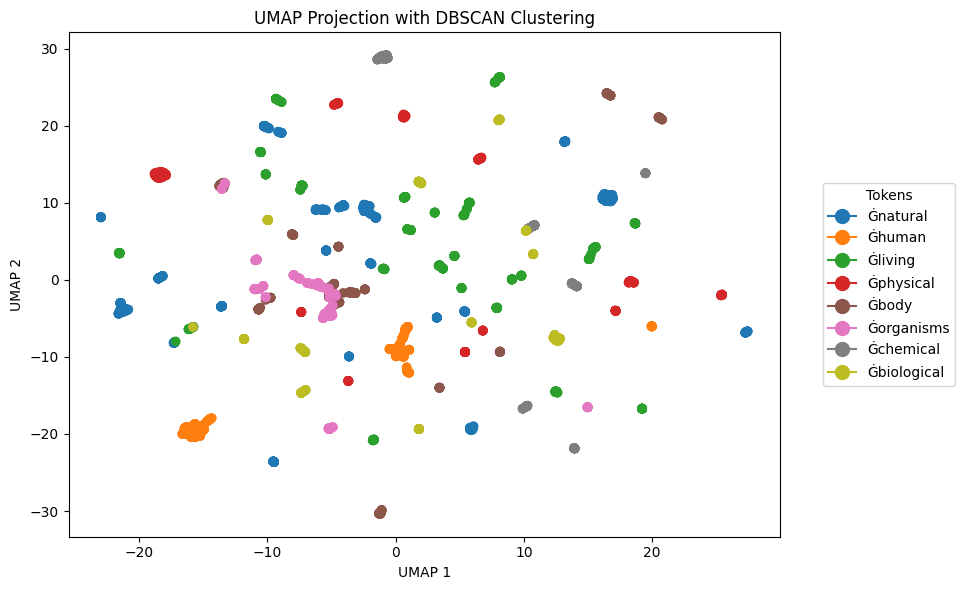

In [370]:
umap_model = umap.UMAP(n_components=2) 
X_umap = umap_model.fit_transform(all_data)

cmap = plt.get_cmap('tab10')  
norm = plt.Normalize(vmin=0, vmax=len(token_list)) 


plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=color_labels, cmap=cmap, norm=norm)
handles = []
for i in range(len(token_list)):
    color = cmap(norm(i)) 
    handle = mlines.Line2D([], [], marker='o', color=color, markerfacecolor=color, markersize=10, label=token_list[i])
    handles.append(handle)

plt.title('UMAP Projection with DBSCAN Clustering')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.legend(handles=handles, title="Tokens", bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show()

/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


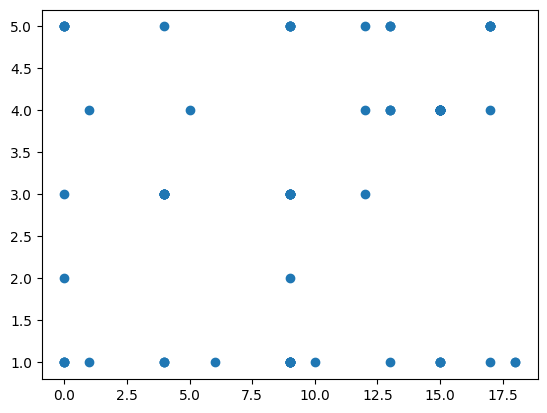

In [374]:
ind1, ind2 = 0, 1

umap1 = umap.UMAP(n_components=2)
X1= umap1.fit_transform(act_data[ind1])
dbscan1 = DBSCAN(eps=1.0, min_samples=5)
labels1 = dbscan1.fit_predict(X1)

umap2 = umap.UMAP(n_components=2)
X2 = umap2.fit_transform(act_data[ind2])
dbscan2 = DBSCAN(eps=1.0, min_samples=5)
labels2 = dbscan1.fit_predict(X2)


app_tog1 = []
sh_labels = []

for r, (i, j) in enumerate(result2[token_list[ind1]]):
    for q, (k, l) in enumerate(result2[token_list[ind2]]):
        if i == k:
            sh_labels.append((labels1[r],labels2[q]))

sh_labels = np.array(sh_labels)
plt.scatter(sh_labels[:, 0], sh_labels[:, 1])
plt.title('Pairwise Cluster Labels')
plt.xlabel(token_list[ind1] + ' Cluster Labels')
plt.ylabel(token_list[ind2] + ' Cluster Labels')